[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/multi-modal/clip-search/clip-text-image-search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/multi-modal/clip-search/clip-text-image-search.ipynb)

# Text-to-Image and Image-to-image search Using CLIP

@Author: Zoumana KEITA
https://zoumanakeita.medium.com/

In [1]:
import torch

print(torch.__version__)

2.2.0+cu118


# Import libraries

In [3]:
import os
import torch
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel

c:\Users\phuon\anaconda3\envs\django_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image Exploration

## Load Data

In [4]:
image_data_df = pd.read_csv('./flickr30k_images/results.csv',delimiter='|')

In [5]:
image_data_df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


We will select a sample of 300 images from this large number of images (3 318 333)

In [6]:
image_data_df.count()

image_name         20
 comment_number    20
 comment           20
dtype: int64

In [7]:
"""
Not all the URLs are valid. This function returns True if the URL is valid. False otherwise.
"""
def filter_animal(sentence): # để dành cái này check animal sài
    animal_dictionary_df = pd.read_csv("animal_dictionary.csv",header=None)
    rows_list = animal_dictionary_df[0].values
    
    if isinstance(sentence, str):
        # Chuyển câu về chữ thường để so sánh không phân biệt chữ hoa/chữ thường
        sentence_lower = sentence.lower()

        # Kiểm tra xem từng từ trong mảng có xuất hiện trong câu không
        for word in rows_list:
            sentence_word = sentence_lower.split(" ")
            if word.lower() in sentence_word:
                return True  # Nếu có ít nhất một từ xuất hiện, trả về True
    else:
        print("🌷")
        print(type(sentence))
        print(sentence)
    return False  # Nếu không có từ nào xuất hiện, trả về False

def get_image(image_path):
    
    image = Image.open(f"flickr30k_images/{image_path}").convert("RGB")

    return image

def get_image_caption(image_ID):

    return image_data_df.loc[image_ID][' comment']

In [8]:
# Transform dataframe
image_data_df["is_animal"] = image_data_df[" comment"].apply(filter_animal)

In [9]:
image_data_df = image_data_df[image_data_df["is_animal"]==True]
image_data_df

,image_name,comment_number,comment,is_animal


In [10]:
image_data_df["image"] = image_data_df["image_name"].apply(get_image)

In [11]:
image_data_df.head(5)

,image_name,comment_number,comment,is_animal,image


In [12]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [13]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

preprocessor_config.json: 100%|██████████| 316/316 [00:00<00:00, 105kB/s]
c:\Users\phuon\anaconda3\envs\django_env\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\phuon\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# Create Embeddings: Text and Image Embeddings

## Text Embeddings

In [14]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [15]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df

In [16]:
image_data_df = get_all_text_embeddings(image_data_df, " comment")

## Image Embeddings

In [17]:
def get_single_image_embedding(my_image):

  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

### Get the embedding of all the images

In [18]:
def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [19]:
image_data_df = get_all_images_embedding(image_data_df, "image")

In [20]:
image_data_df.head()

,image_name,comment_number,comment,is_animal,image,text_embeddings,img_embeddings


In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

def plot_images_by_side(top_images):
  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values]
  list_captions = [top_images.iloc[idx][' comment'] for idx in index_values]
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

  n_col = 2
  n_row = int(top_images.shape[0]/2)
  print("🌷:",n_row)

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

# Perform Similarity Search: Cosine

## 1. Cosine Similarity Search

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
def get_top_N_images(query, data, top_K=10, search_criterion="text"):

    """
    Retrieve top_K (5 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search
    else:
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = [" comment", "image", "cos_sim"]

    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    """
    Sort Cosine Similarity Column in Descending Order
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False).drop_duplicates(subset='image_name')[1:top_K+1]

    return most_similar_articles[revevant_cols].reset_index()

In [24]:
image_data_df.columns

Index(['image_name', ' comment_number', ' comment', 'is_animal', 'image',
       'text_embeddings', 'img_embeddings'],
      dtype='object')

### a. Text to image search

In [25]:
# query_caption = image_data_df.iloc[10].caption
query_caption = "dog run on beach"


top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

Query: dog run on beach


,index,comment,image,cos_sim


In [26]:
plot_images_by_side(top_images)

🌷: 0


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x1200 with 0 Axes>

### a. Image to image search

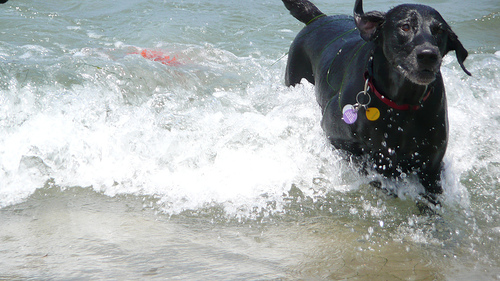

In [ ]:
query_image = image_data_df.iloc[55].image
query_image

🌷: 5


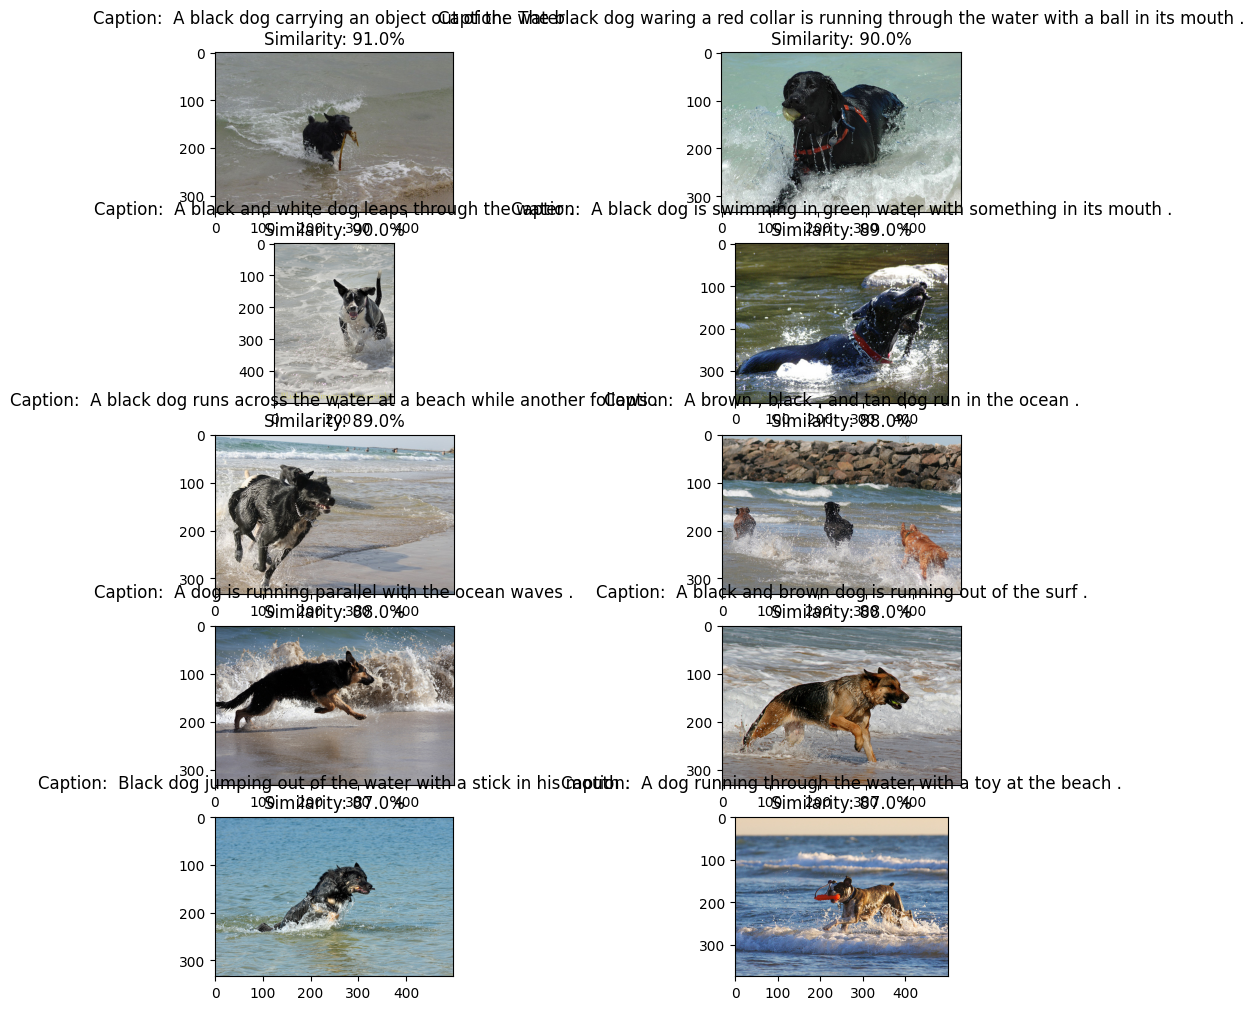

In [ ]:
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
plot_images_by_side(top_images)